In [18]:
import torch as th
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, scatter
from IPython.display import display, clear_output
device = th.device('cpu')
# pqr
P = 3
Q = 301
R = 3
# klmn
N1 = 5
N2 = 5
N3 = 5
N4 = 140
# abcd
W1 = 5
W2 = 5
W3 = 5
W4 = 5
# xy
X1 = 5
X2 = 5

METER = 1e9
SEC = 1

dtype = th.complex128
real = th.float64
width1_t, width2_t, width3_t, width4_t = \
85e-6 * METER, 85e-6 * METER, 1778e-6 * METER, 85e-6 * METER
x1_t, x2_t = \
0.009815 * METER, 0.489 * METER

In [19]:
width1_range = (10e-6, 100e-6)
width2_range = (50e-6, 100e-6)
width3_range = (1500e-6, 2000e-6)
width4_range = (50e-6, 100e-6)
x1_range = (0.007, 0.01)
x2_range = (0.35, 0.6)
position1_range = (1e-3, 10e-3)
position2_range = (16e-3, 10e-3)
position3_range = (1e-3, 10e-3)
position4_range = (1e-3, 8e-3)
lamb = 670e-9
def simulate():
    with th.no_grad():
        th.cuda.empty_cache()

        width1, width2, width3, width4 = \
        np.linspace(width1_range[0], width1_range[1], W1) * METER, \
        np.linspace(width2_range[0], width2_range[1], W2) * METER, \
        np.linspace(width3_range[0], width3_range[1], W3) * METER, \
        np.linspace(width4_range[0], width4_range[1], W4) * METER

        x1, x2 = \
        th.linspace(x1_range[0], x2_range[1], X1, device=device) * METER, \
        th.linspace(x2_range[0], x2_range[1], X2, device=device) * METER

        if X1 == 1: x1 = th.tensor([x1_t], device=device)
        if X2 == 1: x2 = th.tensor([x2_t], device=device)
        if W3 == 1: width3 = np.array([width3_t])

        LAMBDA = lamb * METER
        K = 2 * np.pi / LAMBDA
        MUL = lambda x: th.exp(1j * K * x) / x
        position1 = np.linspace(position1_range[0], position1_range[1], N1) * METER
        position2 = np.linspace(position2_range[0], position2_range[1], N2) * METER
        position3 = np.linspace(position3_range[0], position3_range[1], N3) * METER
        position4 = np.linspace(position4_range[0], position4_range[1], N4) * METER

        field1 = th.tensor(np.linspace(position1, position1[None, :] + width1[:, None], P), dtype=dtype, device=device) # P, W1, N1
        field2 = th.tensor(np.linspace(position2, position2[None, :] + width2[:, None], P), dtype=dtype, device=device) # P, W2, N2
        field3 = th.tensor(np.linspace(position3, position3[None, :] + width3[:, None], Q), dtype=dtype, device=device) # Q, W3, N3
        field4 = th.tensor(np.linspace(position4, position4[None, :] + width4[:, None], R), dtype=dtype, device=device) # R, W4, N4

        E1 = th.ones_like(field1, dtype=dtype, device=device) # P, W1, N1
        E2 = th.ones_like(field2, dtype=dtype, device=device) # P, W2, N2

        D1 = th.sqrt((x1 ** 2)[:, None, None, None, None, None, None] + 
            th.square(field1[:, None, :, None, :, None]-field3[None, :, None, :, None, :])[None, ...]) 
        # X1, P, Q, W1, W3, N1, N3
        D2 = th.sqrt((x1 ** 2)[:, None, None, None, None, None, None] + 
            th.square(field2[:, None, :, None, :, None]-field3[None, :, None, :, None, :])[None, ...])
        # X1, P, Q, W2, W3, N2, N3
        D3 = th.sqrt((x2 ** 2)[:, None, None, None, None, None, None] + 
            th.square(field3[:, None, :, None, :, None]-field4[None, :, None, :, None, :])[None, ...])
        # X2, Q, R, W3, W4, N3, N4
        E3 = th.einsum('xpqackm,pak->xqackm', MUL(D1), E1)[:, :, :, None, :, :, None, :] \
        + th.einsum('xpqbclm,pbl->xqbclm', MUL(D2), E2)[:, :, None, :, :, None, :, :]
        # X1, Q, W1, W2, W3, N1, N2, N3

        th.cuda.empty_cache()
        result = th.abs(th.einsum('yqrcdmn,xqabcklm->xyrabcdklmn', MUL(D3), E3))
        # X1, X2, R, W1, W2, W3, W4, N1, N2, N3, N4
        
        max_val, _ = th.max(result, dim=-1)
        result = result / max_val[..., None]
    return result

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# path = "./LASER/B-1/"
# filename = lambda x: path + "B-1_DoubleSlit_" + str(x) + ".csv"
filename = lambda x:"/Users/rainy21/IPL1/single-photon-interference/LASER/B-3/B-3_AsymmDoubleSlit_Blocker2.33_14.csv"
POSITION_COL = "detector_position(mm)"
VOLTAGE_COL = "voltage(V)"
MILIVOLTE_COL = "voltage(mV)"

def get_data(x):
  data = pd.read_csv(filename(x))
  if MILIVOLTE_COL in data.columns:
    data[VOLTAGE_COL] = data[MILIVOLTE_COL] / 1000
  data = data[data[POSITION_COL] < 8]
  pos = data[POSITION_COL]
  volt = data[VOLTAGE_COL]
  return pos, volt

def plot_data(x, volt=None):
  pos, origninal_volt = get_data(x)
  if volt == None: volt = origninal_volt
  # plt.plot(pos, volt, color='red', linestyle='solid', marker='o', mfc='black', mec='black', ms=3)
  plt.scatter(pos, volt, color='black', s=4)
  plt.xlabel("Detecor Position (mm)")
  plt.ylabel("Output Voltage (V)")
  plt.title(f"Detecor Position vs Output Voltage({str(x)})")

def unravel_index(index, shape):
  out = []
  for dim in reversed(shape):
    out.append(index % dim)
    index = int(index) // dim
  return tuple(reversed(out))

def update_range(range, ind, length):
  space = (range[1] - range[0]) / length
  if ind == 0:
    return (range[0], range[0] + space)
  elif ind == length - 1:
    return (range[1] - space, range[1])
  else:
    return (range[0] + space * (ind - 1), range[0] + space * (ind + 1))
  
def get_value_from_range(range, ind, length):
  if length == 1: return range[0]
  return range[0] + (range[1] - range[0]) / (length-1) * ind

# X1, X2, W1, W2, W3, W4, N1, N2, N3
def print_param_values(incidices):
  print("Slit <-> Blocker: ", get_value_from_range(x1_range, incidices[0], X1) * 1e3, "mm", "True: 9.815mm")
  print("Blocker <-> Detector: ", get_value_from_range(x2_range, incidices[1], X2) * 1e3, "mm", "True: 489mm")
  print("Slit Width: ", get_value_from_range(width1_range, incidices[2], W1) * 1e6, "µm, ", get_value_from_range(width2_range, incidices[3], W2) / METER * 1e6, "µm", "True: 85µm")
  print("Blocker Width: ", get_value_from_range(width3_range, incidices[4], W3) * 1e6, "mm", "True: 1.778mm")
  print("Detector Width: ", get_value_from_range(width4_range, incidices[5], W4) * 1e6, "mm", "True: 85µm")
  print("Slit Position: ", get_value_from_range(position1_range, incidices[6], N1) * 1e3, "mm, ", get_value_from_range(position2_range, incidices[7], N2) * 1e3, "mm")
  print("Inter-slit Distance: ", abs(get_value_from_range(position1_range, incidices[6], N1) * 1e3 - get_value_from_range(position2_range, incidices[7], N2) * 1e3), "mm", "True: Dependss")
  print("Blocker Position: ", get_value_from_range(position3_range, incidices[8], N3) * 1e3, "mm")

Slit <-> Blocker:  10.0 mm True: 9.815mm
Blocker <-> Detector:  350.0 mm True: 489mm
Slit Width:  35.2 µm,  9.000000000000001e-08 µm True: 85µm
Blocker Width:  1983.2 mm True: 1.778mm
Detector Width:  53.84 mm True: 85µm
Slit Position:  5.68 mm,  11.26144 mm
Inter-slit Distance:  5.581440000000001 mm True: Dependss
Blocker Position:  4.024 mm


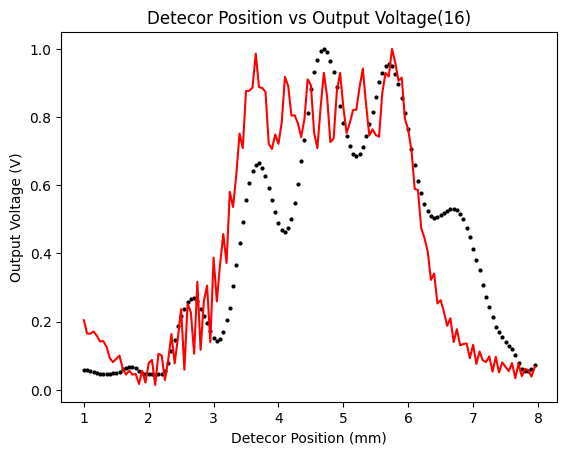

KeyboardInterrupt: 

In [21]:
tol = 1e-3
error_min = 1
pos, volt = get_data(16)
pos = pos.to_numpy()
pos_range = (pos[0] * 1e-3, pos[-1] * 1e-3); pos_count = len(pos)
volt = np.array(volt)
volt = volt / np.max(volt)
volt = th.tensor(volt, dtype=real, device=device)
position4_range = pos_range
N4 = pos_count
position4 = th.linspace(position4_range[0], position4_range[1], N4, device=device) * METER
while tol < error_min:
  result = simulate()
  error = (th.sum(th.square(result-volt), dim=-1))
  # error min 위치
  arg = th.argmin(error)
  incices = unravel_index(arg, error.shape)
  error_min = float(error[incices].cpu())
  plot(position4/ METER * 1e3, result[incices].cpu().numpy(), color='r')
  incices = list(incices)
  # X1, X2, W1, W2, W3, W4, N1, N2, N3
  range_list = []
  for index, range, steps in zip(incices, 
    [x1_range, x2_range, width1_range, width2_range, width3_range, width4_range, position1_range, position2_range, position3_range],
    [X1, X2, W1, W2, W3, W4, N1, N2, N3]):
    range_list.append(update_range(range, index, steps)) # weird code
  position1_range, position2_range, width1_range, width2_range, width3_range, width4_range, position1_range, position2_range, position3_range = range_list
  plot_data(16, volt.cpu())
  clear_output(wait=True)
  print_param_values(incices)
  plt.show()

In [ ]:
a = 1
b = 2
li = []
for i, j in zip([2, 3], [a, b]):
  li.append(i)
a, b = li
print(a, b)

2 3


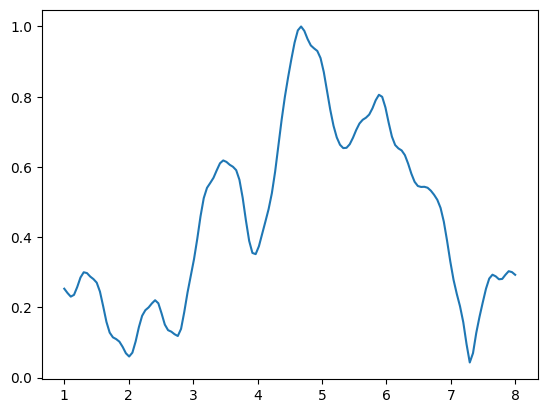

In [ ]:


plot(position4/ METER * 1e3, result[unravel_index(arg, error.shape)].cpu())

In [ ]:
# X1, X2, W1, W2, W3, W4, N1, N2, N3
def print_param_values(incidices):
  print("Slit <-> Blocker: ", float(x1[incidices[0]] / METER * 1e3), "mm", "True: 9.815mm")
  print("Blocker <-> Detector: ", float(x2[incidices[1]] / METER * 1e3), "mm", "True: 489mm")
  print("Slit Width: ", width1[incidices[2]] / METER * 1e6, "µm, ", width2[incidices[3]] / METER * 1e6, "µm", "True: 85µm")
  print("Blocker Width: ", width3[incidices[4]] / METER * 1e6, "mm", "True: 1.778mm")
  print("Detector Width: ", width4[incidices[5]] / METER * 1e6, "mm", "True: 85µm")
  print("Slit Position: ", position1[incidices[6]] / METER * 1e3, "mm, ", position2[incidices[7]] / METER * 1e3, "mm")
  print("Inter-slit Distance: ", abs(position1[incidices[6]] / METER * 1e3 - position2[incidices[7]] / METER * 1e3), "mm", "True: Dependss")
  print("Blocker Position: ", position3[incidices[8]] / METER * 1e3, "mm")

print_param_values(unravel_index(arg, error.shape))

Slit <-> Blocker:  9.8149995803833 mm True: 9.815mm
Blocker <-> Detector:  489.0 mm True: 489mm
Slit Width:  43.15789473684211 µm,  84.21052631578948 µm True: 85µm
Blocker Width:  1778.0 mm True: 1.778mm
Detector Width:  50.0 mm True: 85µm
Slit Position:  1.0 mm,  10.0 mm
Inter-slit Distance:  9.0 mm True: Dependss
Blocker Position:  3.25 mm


In [ ]:
arg

tensor(78740)